Link to step 6 [Notebook_6](https://github.com/fatsoengineer/Computer_Vision_Course/blob/master/S5/6th_Model_Layer_image_aug.ipynb)
## Step 7

 **Target:**

> Adding LR scheduler


**Results**


> 
*   Total params: 6,376
*   Best Test Accuracy: 
```
EPOCH:14 | LR: [0.008679444396382234]
Loss=0.018181532621383667 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:16<00:00, 55.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]
Test set: Average loss: 0.0178, Accuracy: 9947/10000 (99.47%)
```


**Analysis**

> * Tried Step LR or ReduceLrOnPlateau schedulers to check the results, but got the best result with OneCycleLR.
* Ran multiple times to confirm that the results are not fluke or not fluctuating from each training at large 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
cd /content/drive/My Drive/Backup/EVP/Session_6

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
from torchsummary import summary

!!pip install mlcrate
import mlcrate as mlc

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                      #  transforms.RandomErasing()
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [0]:
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


# The model
Let's start with the model we first saw

In [0]:
dropout_value =.10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), #26
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #24
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            # nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #22
            # nn.BatchNorm2d(12),
            # nn.ReLU(),
            # nn.Dropout(dropout_value),

            nn.MaxPool2d(2,2), # 11
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #9
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #7
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value),
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.reducer = nn.Conv2d(12,10,1,bias=False)

    def forward(self, x):
      x= self.conv1(x)
      x= self.conv2(x)
      x= self.conv3(x)
      x =self.gap(x)
      x= self.reducer(x)
      x = x.view(-1, 10)
      return F.log_softmax(x)

Batch Norm after Relu


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             864
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,296
      BatchNorm2d-11           [-1, 12, 10, 10]              24
             ReLU-12           [-1, 12, 10, 10]               0
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:

from tqdm import tqdm




def train(model, device, train_loader, optimizer, epoch,scheduler):
  # train_losses = []
  # train_acc = []

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  train_acc = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    # train_losses.append(loss)
    train_loss += F.nll_loss(y_pred, target, reduction='sum').item()  # sum up batch loss
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    
    # train_acc.append(100*correct/processed)
    scheduler.step()
  train_acc = 100*correct/processed
  train_loss /= len(train_loader.dataset)
  return train_loss, train_acc
    
def test(model, device, test_loader):
  # test_losses = []

  # test_acc = []

  model.eval()
  test_loss = 0
  test_acc = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()




  test_loss /= len(test_loader.dataset)
  # test_losses.append(test_loss)
  test_acc = 100. * correct / len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      test_acc))
  # test_acc.append(acc)

  return test_loss, test_acc


In [0]:
def run_model(model, device, train_loader, optimizer, scheduler, test_loader, EPOCHS, logger):
  train_loss_list = []
  train_acc_list = []
  test_losses_list = []
  test_acc_list = []
  for epoch in range(1,EPOCHS+1):
      print(f"EPOCH:{epoch} | LR: {scheduler.get_lr()}")
      train_loss, train_acc= train(model, device, train_loader, optimizer, epoch, scheduler)
      test_loss, test_acc= test(model, device, test_loader)
      train_loss_list.append(train_loss)
      train_acc_list.append(train_acc)
      test_losses_list.append(test_loss)
      test_acc_list.append(test_acc)
      logger.write(["base_model",epoch, optimizer.param_groups[0]['lr'], train_loss, test_loss, train_acc, test_acc])
  return train_loss_list, train_acc_list, test_losses_list, test_acc_list

# Let's Train and test our model

In [13]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=EPOCHS)

timer = mlc.time.Timer()
logger = mlc.LinewiseCSVWriter('train_log_base_model.csv', header=["iteration_type", 'epoch', 'lr', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])

train_losses, train_acc, test_losses, test_acc = run_model(model, device, train_loader, optimizer, scheduler, test_loader, EPOCHS, logger)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH:1 | LR: [0.0040000000000000036]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.2740268111228943 Batch_id=937 Accuracy=83.51: 100%|██████████| 938/938 [00:23<00:00, 40.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1262, Accuracy: 9634/10000 (96.34%)

EPOCH:2 | LR: [0.005635849325882514]


Loss=0.20504499971866608 Batch_id=937 Accuracy=96.87: 100%|██████████| 938/938 [00:22<00:00, 41.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9854/10000 (98.54%)

EPOCH:3 | LR: [0.010431897177822128]


Loss=0.016836166381835938 Batch_id=937 Accuracy=97.42: 100%|██████████| 938/938 [00:22<00:00, 41.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9833/10000 (98.33%)

EPOCH:4 | LR: [0.018061243070589844]


Loss=0.06541155278682709 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:23<00:00, 40.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9854/10000 (98.54%)

EPOCH:5 | LR: [0.028003867823535325]


Loss=0.07931198179721832 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:23<00:00, 40.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9892/10000 (98.92%)

EPOCH:6 | LR: [0.039582078270008196]


Loss=0.09652256965637207 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:23<00:00, 40.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9899/10000 (98.99%)

EPOCH:7 | LR: [0.052006699086933936]


Loss=0.030245214700698853 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:22<00:00, 40.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9885/10000 (98.85%)

EPOCH:8 | LR: [0.06443086329149111]


Loss=0.018383145332336426 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:22<00:00, 50.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9914/10000 (99.14%)

EPOCH:9 | LR: [0.07600773502373485]


Loss=0.11379065364599228 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:22<00:00, 48.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9915/10000 (99.15%)

EPOCH:10 | LR: [0.08594823020787264]


Loss=0.004249051213264465 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:22<00:00, 48.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.13%)

EPOCH:11 | LR: [0.09357480082949156]


Loss=0.017527639865875244 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:22<00:00, 41.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.18%)

EPOCH:12 | LR: [0.09836761687150115]


Loss=0.012591227889060974 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:23<00:00, 40.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9910/10000 (99.10%)

EPOCH:13 | LR: [0.0999999996423022]


Loss=0.2519015967845917 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:22<00:00, 40.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9923/10000 (99.23%)

EPOCH:14 | LR: [0.09968494176273295]


Loss=0.00715424120426178 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:22<00:00, 45.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9927/10000 (99.27%)

EPOCH:15 | LR: [0.09874506942773865]


Loss=0.09072524309158325 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:22<00:00, 40.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9931/10000 (99.31%)

EPOCH:16 | LR: [0.09719220207725855]


Loss=0.05641084909439087 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:22<00:00, 41.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH:17 | LR: [0.09504586791921951]


Loss=0.0031038671731948853 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:23<00:00, 40.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9904/10000 (99.04%)

EPOCH:18 | LR: [0.09233305835099098]


Loss=0.028632938861846924 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:22<00:00, 41.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9919/10000 (99.19%)

EPOCH:19 | LR: [0.0890878885269022]


Loss=0.009815365076065063 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:23<00:00, 40.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9918/10000 (99.18%)

EPOCH:20 | LR: [0.08535116834038248]


Loss=0.032349273562431335 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:22<00:00, 47.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

EPOCH:21 | LR: [0.08116988921587286]


Loss=0.07763814926147461 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:22<00:00, 40.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

EPOCH:22 | LR: [0.0765966331643987]


Loss=0.0055937618017196655 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:23<00:00, 40.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9922/10000 (99.22%)

EPOCH:23 | LR: [0.07168891153427225]


Loss=0.07991407066583633 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:22<00:00, 40.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH:24 | LR: [0.06650844177251879]


Loss=0.007526099681854248 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:23<00:00, 40.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9932/10000 (99.32%)

EPOCH:25 | LR: [0.061120371292170905]


Loss=0.0017424523830413818 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:23<00:00, 40.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH:26 | LR: [0.05559245820575031]


Loss=0.0041583627462387085 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:23<00:00, 40.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

EPOCH:27 | LR: [0.04999421922768861]


Loss=0.02055002748966217 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:22<00:00, 41.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9941/10000 (99.41%)

EPOCH:28 | LR: [0.044396055461308856]


Loss=0.01650775969028473 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:22<00:00, 41.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH:29 | LR: [0.03886836706410354]


Loss=0.0010309219360351562 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:23<00:00, 40.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

EPOCH:30 | LR: [0.03348066792490705]


Loss=0.0608416348695755 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:22<00:00, 40.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

EPOCH:31 | LR: [0.0283007114864106]


Loss=0.004074767231941223 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:22<00:00, 40.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH:32 | LR: [0.023393638706309047]


Loss=0.029135242104530334 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:23<00:00, 40.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH:33 | LR: [0.018821158871962108]


Loss=0.003718271851539612 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:22<00:00, 40.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH:34 | LR: [0.014640773570301302]


Loss=0.00886237621307373 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:22<00:00, 40.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

EPOCH:35 | LR: [0.010905053572011027]


Loss=0.008782148361206055 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:23<00:00, 40.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH:36 | LR: [0.007660977723585038]


Loss=0.006446048617362976 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:23<00:00, 40.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

EPOCH:37 | LR: [0.004949342161073944]


Loss=0.018584072589874268 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:23<00:00, 40.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

EPOCH:38 | LR: [0.0028042472750039044]


Loss=0.11298640072345734 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:22<00:00, 41.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)

EPOCH:39 | LR: [0.0012526688781803186]


Loss=0.03653360903263092 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:22<00:00, 47.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

EPOCH:40 | LR: [0.00031411896918998847]


Loss=0.09249767661094666 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:30<00:00, 30.50it/s]



Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)



In [0]:
# train_losses_idx, train_acc, test_losses, test_acc


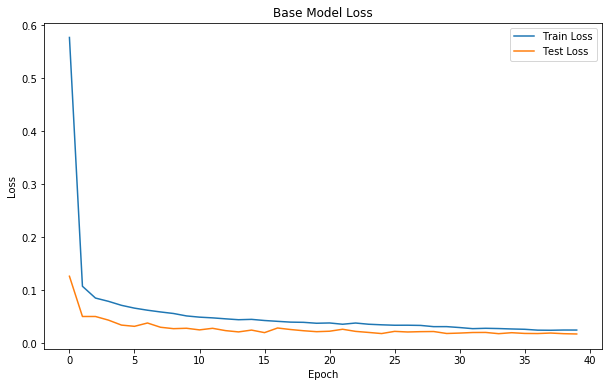

In [14]:
plt.figure(1, figsize=[10,6])
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Base Model Loss")
plt.savefig("Base Model loss.png")

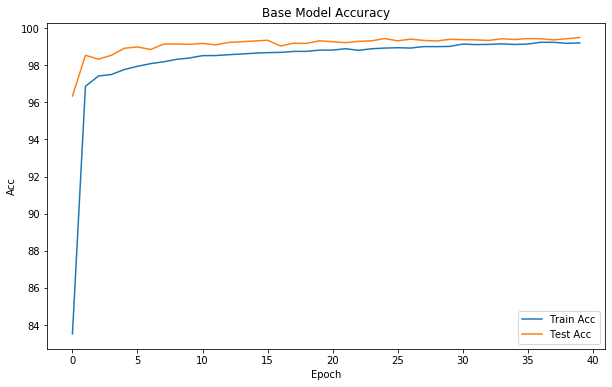

In [15]:
plt.figure(1, figsize=[10,6])
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(['Train Acc', 'Test Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title("Base Model Accuracy")
plt.savefig("Base Model Accuracy.png")